In [1]:
import json
import networkx as nx
import random

In [2]:
tests = True

In [3]:
def gen_grid_graph(dim, weight_range):
    G = nx.grid_2d_graph(*dim).to_directed()
    for u, v in list(G.edges):
        if u[0] > v[0] or u[1] > v[1]:
            G.remove_edge(u, v)
    
    G.add_node('s')
    G.add_node('t')
    for x in G.nodes:
        if x != 's' and x != 't':
            if x[1] == 0:
                G.add_edge('s', x)
            if x[1] == dim[1] - 1:
                G.add_edge(x, 't')
    
    relabel_map = {}
    for x in G.nodes:
        if x != 's' and x != 't':
            relabel_map[x] = x[0] * dim[1] + x[1]
    G = nx.relabel_nodes(G, relabel_map)
    
    for u, v in G.edges:
        G[u][v]['weight'] = random.randint(*weight_range)
    
    return G

In [4]:
def visualize_graph(G):
    pos = nx.nx_agraph.graphviz_layout(G)
    nx.draw(G, pos, with_labels=True)
    labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

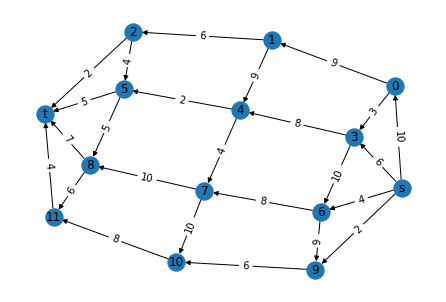

In [5]:
if tests:
    G = gen_grid_graph((4, 3), (1, 10))
    visualize_graph(G)

In [6]:
def gen_int_weights(G, weight_range):
    int_weights = {}
    for u, v in G.edges:
        int_weights[(u, v)] = random.randint(*weight_range)
    return int_weights

In [7]:
def pprint_dict(d):
    print(json.dumps({str(key): d[key] for key in d}, indent=4))

In [8]:
if tests:
    G = gen_grid_graph((5, 5), (1, 10))
    int_weights = gen_int_weights(G, (1, 10))
    pprint_dict(int_weights)

{
    "(0, 5)": 1,
    "(0, 1)": 1,
    "(1, 6)": 5,
    "(1, 2)": 6,
    "(2, 7)": 4,
    "(2, 3)": 8,
    "(3, 8)": 8,
    "(3, 4)": 1,
    "(4, 9)": 4,
    "(4, 't')": 3,
    "(5, 10)": 9,
    "(5, 6)": 2,
    "(6, 11)": 3,
    "(6, 7)": 1,
    "(7, 12)": 2,
    "(7, 8)": 2,
    "(8, 13)": 6,
    "(8, 9)": 8,
    "(9, 14)": 4,
    "(9, 't')": 6,
    "(10, 15)": 8,
    "(10, 11)": 1,
    "(11, 16)": 9,
    "(11, 12)": 10,
    "(12, 17)": 1,
    "(12, 13)": 7,
    "(13, 18)": 2,
    "(13, 14)": 9,
    "(14, 19)": 1,
    "(14, 't')": 1,
    "(15, 20)": 3,
    "(15, 16)": 2,
    "(16, 21)": 6,
    "(16, 17)": 9,
    "(17, 22)": 10,
    "(17, 18)": 2,
    "(18, 23)": 3,
    "(18, 19)": 3,
    "(19, 24)": 5,
    "(19, 't')": 3,
    "(20, 21)": 7,
    "(21, 22)": 10,
    "(22, 23)": 9,
    "(23, 24)": 5,
    "(24, 't')": 5,
    "('s', 0)": 9,
    "('s', 5)": 5,
    "('s', 10)": 7,
    "('s', 15)": 6,
    "('s', 20)": 1
}


In [9]:
class ExperimentLogger:
    global_info = ['Experiment Name', '|V|', '|E|', 'Interdiction Budget', 'Number of Refinement Iterations', 'Number of Nodes Per Refinement Partition']
    def __init__(self, solvers, export_path):
        self.info = self.global_info + sum([[f"{x[0]} Objective Value", f"{x[0]} Time"] for x in solvers], [])
        if os.path.exists(export_path):
            self.df = pd.read_csv(export_path)
        else:
            self.df = pd.DataFrame(columns=self.info)
        if os.path.exists('subproblem_gaps.csv'):
            self.gap_df = pd.read_csv('subproblem_gaps.csv')
        else:
            self.gap_df = pd.DataFrame(columns=["Experiment Name", "Solver", "Gap"])
        self.solvers = solvers
        self.export_path = export_path
        
    def log_experiment(self, experiment_name, G, int_vals, budget, refine_iters, refine_partitions):
        curr_experiment = [experiment_name, len(G.nodes), len(G.edges), budget, refine_iters, refine_partitions]
        
        os.mkdir(f"experiments/{experiment_name}")
        nx.write_weighted_edgelist(g, f"experiments/{experiment_name}/graph.edgelist")
        with open(f"experiments/{experiment_name}/interdiction_weight.intvals", 'w+') as f:
            f.write(json.dumps({str(x): int_vals[x] for x in int_vals.keys()}))
        
        for solver in self.solvers:
            print(f"Using {solver[0]} solver")
            
            problem = subprocess.run(["gtime", "-f", "%U", "python3", f"{solver[1]}", experiment_name, str(budget), str(refine_iters), str(refine_partitions)], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            problem_obj = re.search(r'Objective value: (.*?)\.', str(problem.stdout)).group(1)
            problem_time = float(problem.stderr)
            
            curr_experiment.append(problem_obj)
            curr_experiment.append(problem_time)
            
            with open("tmp_gap.txt", "r") as f:
                for x in f.readlines():
                    curr = float(x.strip())
                    self.gap_df.loc[len(self.gap_df.index)] = [experiment_name, solver[0], curr]
            os.remove("tmp_gap.txt")
            
            print()
            
        self.df.loc[len(self.df.index)] = curr_experiment
        self.df.to_csv(self.export_path)
        
        self.gap_df.to_csv("subproblem_gaps.csv")